In [1]:
%reload_ext autoreload
%autoreload 2

import argparse
import os
import glob
import numpy as np
import torch
from networks.mmt import MMT as generator
from torchvision.utils import save_image
from tqdm import tqdm
from configs.config import get_config
from datasets.dataset_brats import BRATS_dataset, RandomGeneratorBRATS
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import Upsample

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

split = 'test'
batch_size = 1
data_dir = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/brats2021_slices_crop192x160'
ckpt_path_zerogad = '/mnt/datasets/jiang/projects/SubtleGAN/model_fluidstack/MMT/MMTUNetHybrid_GAN_ls_zerogad_s_c_MMT_epo50_bs32_lrg0.0005_192_opt-adamw/epoch_31.pth'
ckpt_path_random = '/mnt/datasets/jiang/projects/SubtleGAN/model_fluidstack/MMT/MMTUNetHybrid_GAN_ls_random_s_c_MMT_epo75_bs32_lrg0.0005_192_opt-adamw/epoch_74.pth'
ckpt_path_single = '/mnt/datasets/jiang/projects/SubtleGAN/model/MMT/MMTUNetHybrid_GAN_s_c_MMT_epo50_bs24_lrg0.0005_192_opt-adamw/epoch_49.pth'

ckpt_path = ckpt_path_zerogad

db = BRATS_dataset(base_dir=data_dir, split=split,
                               transform=transforms.Compose(
                                   [RandomGeneratorBRATS(flip=False, scale=None)]))
dataloader = DataLoader(db, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
G = generator(img_size=[160, 192],
                                patch_size=4,
                                in_chans=1,
                                out_chans = 1,
                                embed_dim=96,
                                depths=[2,2,2,2],
                                num_heads=[3,6,12,24],
                                window_size=[5,6],
                                mlp_ratio=4.0,
                                qkv_bias=True,
                                qk_scale=None,
                                drop_rate=0,
                                drop_path_rate=0,
                                ape=False,
                                patch_norm=True,
                                use_checkpoint=False, cross_contrast_attn=True).cuda()
state_dict = torch.load(ckpt_path, map_location='cpu')
G.load_state_dict(state_dict['G'])
G.eval()


/home/srivathsa/miniconda3/envs/mmt/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0
CROSS CONTRAST ATTN= True


/home/srivathsa/miniconda3/envs/mmt/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


MMT(
  (heads): ModuleList(
    (0): Head(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
            (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
        (2): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
            (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
      )
    )
    (1): Head(
      (model): Sequential(
        (0): Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ResBlock(
          (body): Sequential(
            (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): ReLU(inplace=True)
    

In [2]:
def slice_loader(fn):
    data = np.load(fn)
    n_channel = data.shape[0]
    image = torch.from_numpy(data.astype(np.float32)).unsqueeze(0)
    output = [image[:, i, :, :].unsqueeze(0).detach() for i in range(n_channel)]
    return output

In [3]:
def split_data(data, inputs, targets):
    contrast_input = inputs
    contrast_output = targets
    img_inputs = [data[i].detach().cuda() for i in contrast_input]
    img_targets = [data[i].detach().cuda() for i in contrast_output]
    return img_inputs, img_targets, contrast_input, contrast_output

In [4]:
from torch.nn.functional import interpolate
import torch
from torch.nn.functional import softmax

def sum_attn(attn_maps, head_normalization=True):
    n_heads = [24, 24, 12, 12, 6, 6, 3, 3]
    attn = torch.zeros_like(attn_maps[-1][:, :, :, :, 0])
    for n_head, attn_map in zip(n_heads, attn_maps):
        attn_map = attn_map[:, :, :, :, 0]
        scale_factor = 48//attn_map.shape[-1]
        attn_map = interpolate(attn_map, size=(40, 48))/scale_factor**2
        if head_normalization:
            attn_map = attn_map/n_head
        attn += attn_map
    return attn

In [17]:
data = slice_loader('/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/brats2021_slices_crop192x160/test/BraTS2021_01409/077.npy')
data = [d.detach().cuda() for d in data]
img_inputs, img_targets, contrast_input, contrast_output = split_data(data, [0, 2, 3], [1])

In [18]:
outputs, _, attn = G(img_inputs, contrast_input, contrast_output, return_attention=True)

In [19]:
att_sum = sum_attn(attn)
att_sum = softmax(att_sum, dim = 1)
att_sum = torch.rot90(att_sum, 3, [2, 3])

In [20]:
att_sum = att_sum.detach().cpu().numpy()
print(att_sum.shape)

(1, 3, 48, 40)


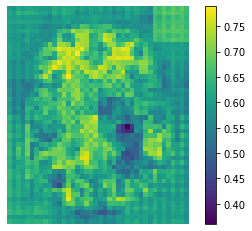

In [21]:
import matplotlib.pyplot as plt
plt.imshow(att_sum[0, 0, :, :])
plt.colorbar()
plt.axis('off')
#plt.clim(0, 1)
plt.savefig("Fig/attn_t1.png")

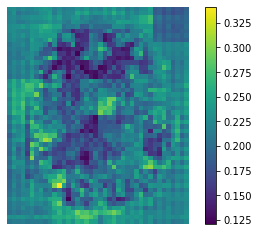

In [22]:
plt.imshow(att_sum[0, 1, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t2.png")

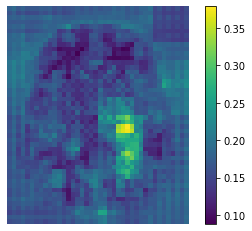

In [23]:
plt.imshow(att_sum[0, 2, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_flair.png")

In [24]:
att_last = torch.rot90(attn[-1], 3, [2, 3])
att_last = softmax(att_last[:, :, :, :, 0], dim=1)
att_last = att_last.detach().cpu().numpy()

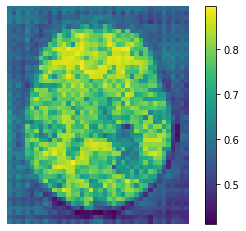

In [25]:
plt.imshow(att_last[0, 0, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t1_last.png")

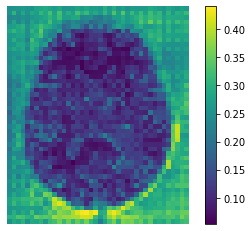

In [26]:
plt.imshow(att_last[0, 1, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_t2_last.png")

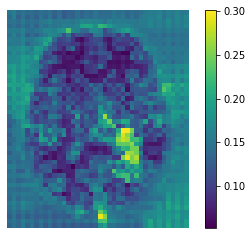

In [27]:
plt.imshow(att_last[0, 2, :, :])
plt.colorbar()
plt.axis('off')
plt.savefig("Fig/attn_flair_last.png")